In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Activation, Dropout
%matplotlib inline

# Data Preparation & Preprocessing

In [5]:
#crop the part that contains only the brain of the image,cropping technique to find the extreme top, 
#bottom, left and right points of the brain.
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

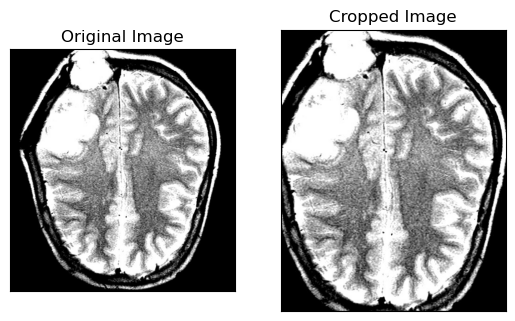

In [7]:
ex_img = cv2.imread('Brain_Tumor_Detection/train/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Load up the data

In [8]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:
augmented_path = 'Brain_Tumor_Detection/train/'
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 3000
X shape is: (3000, 240, 240, 3)
y shape is: (3000, 1)


In [10]:
def plot_sample_images(X, y, n=50): 
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]        
        columns_n = 10
        rows_n = int(n/ columns_n)
        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

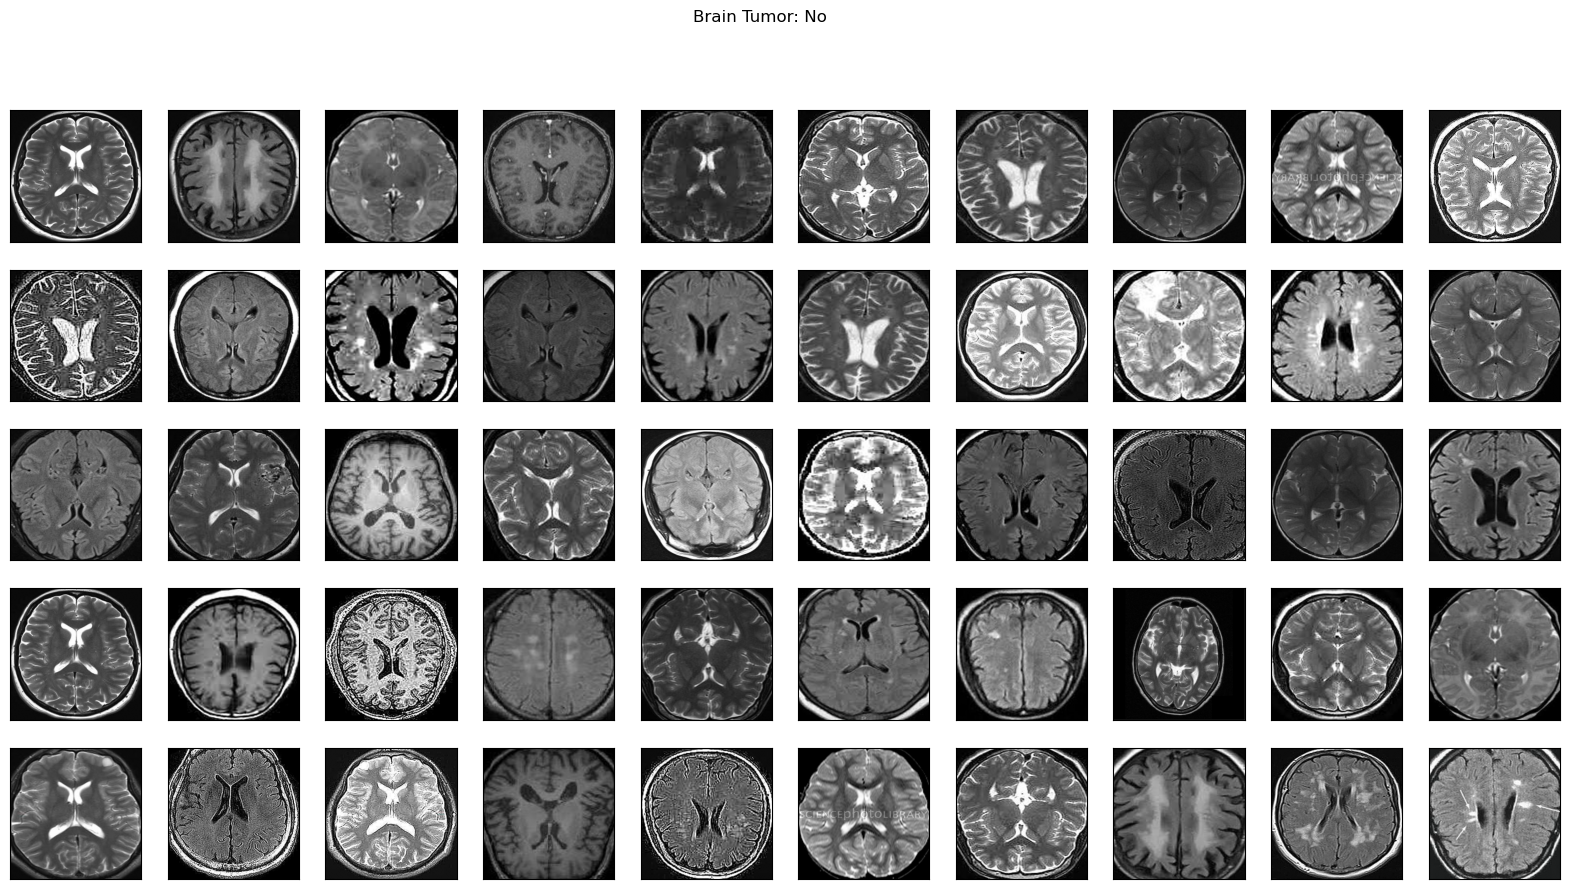

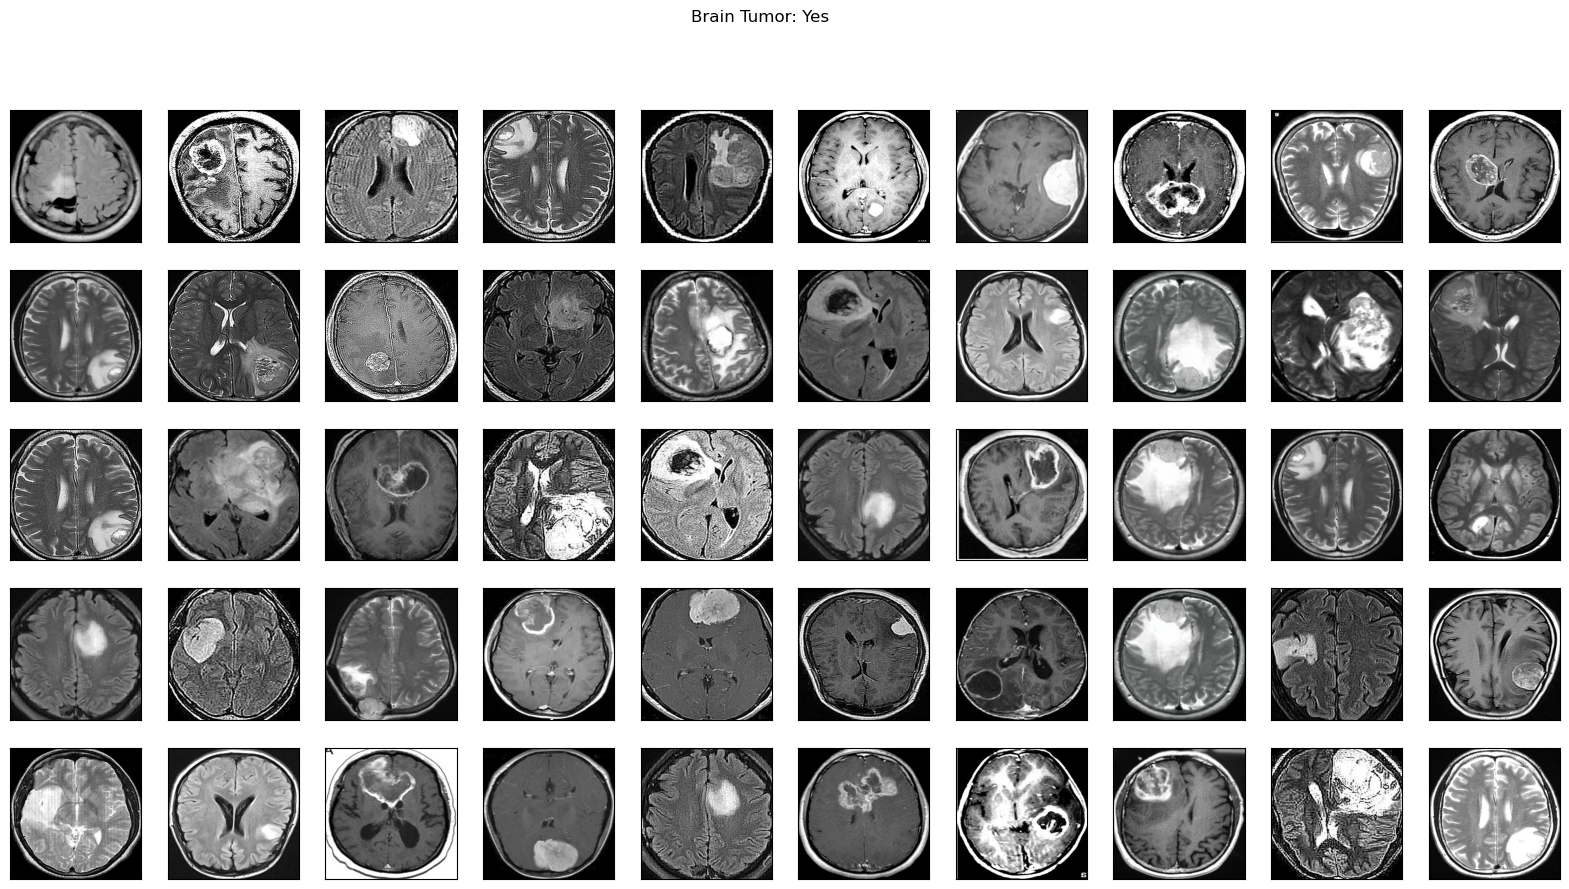

In [11]:
plot_sample_images(X, y)

In [12]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [15]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [16]:
def build_model(input_shape):
    X_input = Input(input_shape) 

    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (2, 2), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 

    X = MaxPooling2D((4, 4), name='max_pool0')(X) 

    X = MaxPooling2D((4, 4), name='max_pool1')(X) 

    X = Flatten()(X) 

    X = Dense(1, activation='sigmoid', name='fc')(X)

    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 119, 119, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 119, 119, 32)      128       
                                                                 
 activation (Activation)     (None, 119, 119, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 29, 29, 32)        0         
                                               

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
66/66 [==============================] - 52s 746ms/step - loss: 0.6758 - accuracy: 0.6405 - val_loss: 0.6431 - val_accuracy: 0.6600
Epoch 2/20
66/66 [==============================] - 48s 721ms/step - loss: 0.4740 - accuracy: 0.7752 - val_loss: 0.5907 - val_accuracy: 0.7044
Epoch 3/20
66/66 [==============================] - 48s 731ms/step - loss: 0.3987 - accuracy: 0.8348 - val_loss: 0.5265 - val_accuracy: 0.7489
Epoch 4/20
66/66 [==============================] - 48s 723ms/step - loss: 0.3818 - accuracy: 0.8357 - val_loss: 0.4867 - val_accuracy: 0.7511
Epoch 5/20
66/66 [==============================] - 47s 720ms/step - loss: 0.3291 - accuracy: 0.8724 - val_loss: 0.4603 - val_accuracy: 0.8000
Epoch 6/20
66/66 [==============================] - 48s 721ms/step - loss: 0.3187 - accuracy: 0.8748 - val_loss: 0.3970 - val_accuracy: 0.8311
Epoch 7/20
66/66 [==============================] - 47s 714ms/step - loss: 0.3080 - accuracy: 0.8729 - val_loss: 0.3594 - val_accuracy: 0.8244

In [20]:
model.save('brain_tumor_detector.h5')

C:\Users\sahil\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


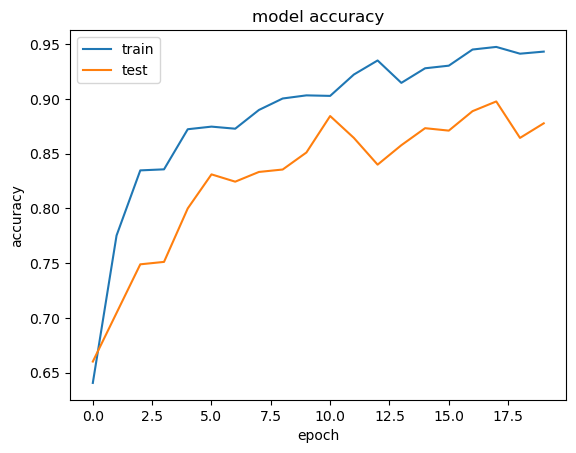

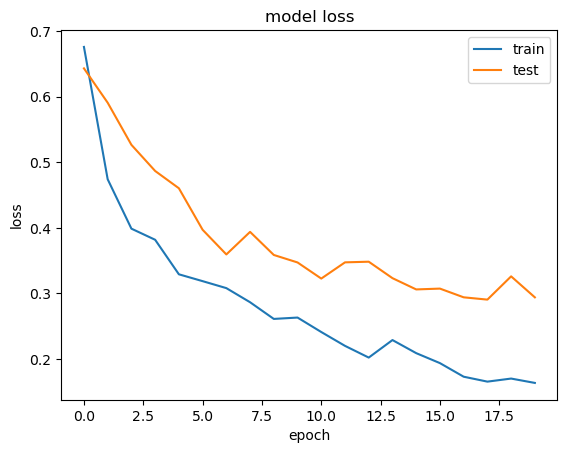

In [21]:
history = model.history
    # print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
    # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()  

In [22]:
loss, acc = model.evaluate(x=X_test, y=y_test)

15/15 [==============================] - 3s 175ms/step - loss: 0.2485 - accuracy: 0.9156


In [23]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.24854299426078796
Test Accuracy = 0.9155555367469788


In [24]:
y_test_prob =model.predict(X_test)

15/15 [==============================] - 3s 184ms/step


In [25]:
print(y_test_prob)

[[9.99967635e-01]
 [3.75007279e-02]
 [9.79371667e-01]
 [1.00694632e-03]
 [1.40227497e-01]
 [9.46270168e-01]
 [8.68569873e-03]
 [2.10599780e-01]
 [8.61877441e-01]
 [7.21819580e-01]
 [9.04925942e-01]
 [9.87476468e-01]
 [8.87100622e-02]
 [1.92782879e-01]
 [6.97319925e-01]
 [7.18881749e-03]
 [9.97118711e-01]
 [7.83431605e-02]
 [2.38670528e-01]
 [8.22596073e-01]
 [7.57855713e-01]
 [9.99428809e-01]
 [7.23119676e-01]
 [1.33173257e-01]
 [3.24592143e-02]
 [4.70608294e-01]
 [8.48177552e-01]
 [3.53448577e-02]
 [1.21837027e-01]
 [9.97920930e-01]
 [1.52509427e-03]
 [8.76809239e-01]
 [2.16847230e-02]
 [6.01700321e-02]
 [9.94982123e-01]
 [7.85712540e-01]
 [7.25934207e-01]
 [7.87546039e-02]
 [7.05039799e-01]
 [8.33441198e-01]
 [8.96399841e-02]
 [9.62164462e-01]
 [9.68072951e-01]
 [9.99052048e-01]
 [1.65391147e-01]
 [9.14604604e-01]
 [9.99701679e-01]
 [1.56655863e-01]
 [2.96331998e-02]
 [9.99712527e-01]
 [1.64355915e-02]
 [8.46872389e-01]
 [9.82707381e-01]
 [9.99857068e-01]
 [1.21275485e-02]
 [6.723348

In [26]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9136363636363636


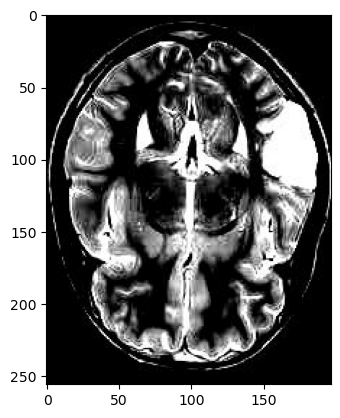

1/1 [==============================] - 0s 47ms/step
Normal


In [32]:
#Sample prediction to check the model performance on new image
image = 'Brain_Tumor_Detection/train/yes/Y14.jpg'
img2 = cv2.imread(image)
plt.imshow(img2.squeeze())
plt.show()
img = cv2.resize(img2,(240,240))
img = np.reshape(img, (1, 240, 240, 3))
classes = (model.predict(img)).astype("float32")
if(classes>=0.5):
    print("Tumor")
else:
    print("Normal")
